## <center> Text Analysis on Reverse Migraton in India due to Covid-19</center>
### <center> Sonali Subbu Rathinam  </center>
#### <center> December 2022 </center>
<br><br>

In [1]:
#Importing required modules
import csv
import json
import requests
import pandas as pd
import numpy as np
import re

#Sklearn packages
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#Additional text analytics libraries
import nltk
from nltk.stem import WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk.corpus import stopwords


#LDA
from gensim import corpora
import gensim
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis 


#Plotting libraries
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline

#To remove warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Reading data obtained from the Replication Paper
df = pd.read_csv("articles.csv")

In [3]:
#Checking data
df.head()

Title   Author  \
0  States clamour for special trains to bring str...  ['Tnn']   
1      Check posts set up to screen exiting migrants  ['Tnn']   
2                Migrant workers want special trains  ['Tnn']   
3         19 migrant workers’ bid to go to UP foiled  ['Tnn']   
4  Bihar govt seeks special trains to bring migra...       []   

                                                Text  \
0  Bihar, Punjab and Telangana on Thursday joined...   
1  A couple convinces a cop to let them pass duri...   
2  Surat: Despite his repeated attempts Srikant Y...   
3  Kolhapur: Police personnel deployed on the San...   
4  21 Nepali nationals arrived from Sasaram in Pa...   

                                             Summary  \
0  Bihar, Punjab and Telangana on Thursday joined...   
1  A couple convinces a cop to let them pass duri...   
2  Surat: Despite his repeated attempts Srikant Y...   
3  Kolhapur: Police personnel deployed on the San...   
4  Acknowledging the logistical nightmare, deputy...   

                                            Keywords  
0  ['workers', 'stranded', 'states', 'migrants', ...  
1  ['posts', 'check', 'workers', 'screen', 'migra...  
2  ['workers', 'bihar', 'luxury', 'private', 'bus...  
3  ['uttar', 'workers', '19', 'institutional', 'h...  
4  ['workers', 'bihar', 'stranded', 'students', '...

In [4]:
#Checking the dimension
df.shape

(2170, 5)

EDA & Pre-Processing - 1 : Checking for missing value

In [5]:
#Checking for missing value
df.isna().sum()

Title       0
Author      0
Text        0
Summary     0
Keywords    0
dtype: int64

EDA  & Pre-Processing - 2 :Summary Statistics and Article Length (Checking for outliers)

In [6]:
#Summary statistics
df.describe()

Title Author  \
count                                                2170   2170   
unique                                               2153      8   
top     Govt: No intra-state migration from Mum, Pune ...     []   
freq                                                    2   1694   

                                                     Text  \
count                                                2170   
unique                                               2148   
top     A letter from the Editor Dear subscriber, Than...   
freq                                                    8   

                                                  Summary  \
count                                                2170   
unique                                               2147   
top     Your support for our journalism is invaluable....   
freq                                                    8   

                                                 Keywords  
count                                                2170  
unique                                               2153  
top     ['bihar', 'state', 'trains', 'labourers', 'mig...  
freq                                                    2

In [7]:
#Counting the number of words in each article
df['text_count'] = df['Text'].str.len()

In [8]:
df.head()

Title   Author  \
0  States clamour for special trains to bring str...  ['Tnn']   
1      Check posts set up to screen exiting migrants  ['Tnn']   
2                Migrant workers want special trains  ['Tnn']   
3         19 migrant workers’ bid to go to UP foiled  ['Tnn']   
4  Bihar govt seeks special trains to bring migra...       []   

                                                Text  \
0  Bihar, Punjab and Telangana on Thursday joined...   
1  A couple convinces a cop to let them pass duri...   
2  Surat: Despite his repeated attempts Srikant Y...   
3  Kolhapur: Police personnel deployed on the San...   
4  21 Nepali nationals arrived from Sasaram in Pa...   

                                             Summary  \
0  Bihar, Punjab and Telangana on Thursday joined...   
1  A couple convinces a cop to let them pass duri...   
2  Surat: Despite his repeated attempts Srikant Y...   
3  Kolhapur: Police personnel deployed on the San...   
4  Acknowledging the logistical nightmare, deputy...   

                                            Keywords  text_count  
0  ['workers', 'stranded', 'states', 'migrants', ...        2936  
1  ['posts', 'check', 'workers', 'screen', 'migra...        1287  
2  ['workers', 'bihar', 'luxury', 'private', 'bus...        2055  
3  ['uttar', 'workers', '19', 'institutional', 'h...        1534  
4  ['workers', 'bihar', 'stranded', 'students', '...        3580

In [9]:
#Summary statistics of number of words
df['text_count'].describe()

count     2170.000000
mean      2119.043779
std       1071.538138
min         67.000000
25%       1449.000000
50%       1998.000000
75%       2591.750000
max      16756.000000
Name: text_count, dtype: float64

In [10]:
#Boxplot - to check for outliers
fig = px.box(df, y='text_count',#title = "Figure 1 : Number of Words in Each News Article", 
                  labels = {'text_count' : 'Number of Words in Article'},
                  color_discrete_sequence = ['teal'], width=450)

fig
#fig.write_image("fig1.png")

Not removing the outliers because - (i) TF-IDF uses normalization with L2 (ii) Longer news articles may have more detailed information that could be important for sentiment analysis/topic modelling. 

EDA & Pre-Processing - 3: Checking for Punctuation

In [11]:
#Function to check all the punctuation 
def check_find_punctuations(text):
    """
    ----------------------------------------------------------------------------------------------------------------------------
    This function takes in a string and finds all the punctuation in it, and returns the punctuation
    ----------------------------------------------------------------------------------------------------------------------------
    Argument  : text of string type
    ----------------------------------------------------------------------------------------------------------------------------
    Return type : string of string type
    ----------------------------------------------------------------------------------------------------------------------------
    """
    # regular expression containing all punctuation
    result = re.findall(r'[^\w\s]', text)
      
    # form a string
    string = "".join(result)
    return (string)

In [12]:
#Converting the text column to list
text_list = list(df['Text'])

#Changing list of lists to one big list
flat_list = [item for sublist in text_list for item in sublist]


In [13]:
#Function Call - Finding punctuation in the big list 
output = check_find_punctuations(str(text_list))

type(output)

str

In [14]:
#Function to Convert the string to list
def Convert(string):
    """
    ------------------------------------------------------------------------------------------------------------------------
    This function converts a string to a list
    ------------------------------------------------------------------------------------------------------------------------
    Argument  : string of string type
    ----------------------------------------------------------------------------------------------------------------------------
    Return type : list 
    """
    list1 = []
    list1[:0] = string
    return list1
 

#Function call
t1 = Convert(output)

#Changing list to dataframe
t1_df = pd.DataFrame(t1)
t1_df

0
0       [
1       '
2       ,
3       ,
4       .
...    ..
121164  .
121165  ,
121166  .
121167  '
121168  ]

[121169 rows x 1 columns]

In [15]:
#Obtaining value counts
t2=t1_df.value_counts()
#Changing to dataframe
t2=pd.DataFrame(t2)
#Rename column name
t2 = t2.rename(columns= {0: 'punctuation_count'})
#Reset index
t2 = t2.reset_index()
t2

0  punctuation_count
0   ,              44602
1   .              37733
2   -               8512
3   “               5685
4   ”               5615
5   '               4397
6   ’               3720
7   )               2249
8   (               2244
9   :               1801
10  "                724
11  ‘                499
12  %                489
13  —                483
14  ₹                467
15  |                336
16  ?                315
17  /                298
18  ;                184
19  –                159
20  \                120
21  &                 94
22  ]                 72
23  [                 71
24  …                 54
25  @                 33
26  ➤                 27
27  ा                 22
28  े                 21
29  !                 21
30  ी                 17
31  #                 15
32  ं                 14
33  ्                 14
34  +                 11
35  *                  8
36  ि                  7
37  $                  6
38  ो                  5
39  ै                  4
40  <                  3
41  >                  3
42  £                  2
43  ।                  2
44  ु                  2
45  `                  2
46  ़                  1
47  ँ                  1
48  ¸                  1
49  €                  1
50  ¨                  1
51  ❤                  1
52  ️                  1

In [16]:
#Saving this result as an excel file in the working directly 
t2.to_excel(r'punctuation.xlsx', index = False)


EDA & Pre-Processing 3.1 - Found Hindi diacritics in the punctuation list - therefore removing all non-ASCII characters as they may act as noise and not add any value. Also we only have stop words in English in Python Packages and not Hindi

In [17]:
def remove_non_ascii(text): 
    """
    ------------------------------------------------------------------------------------------------------------------------
    This function removes all non-ascii characters in a string. Since apply is used, the article text variable for each row
    will be passed as an argument
    ------------------------------------------------------------------------------------------------------------------------
    Argument  : text of string type 
    ----------------------------------------------------------------------------------------------------------------------------
    Return type : string (it will be added as a new column)
    """
    return ''.join(i for i in text if ord(i)<128) 


#Function call to remove Non ASCII characters
df['text_clean'] = df['Text'].apply(remove_non_ascii) 

df.head()

Title   Author  \
0  States clamour for special trains to bring str...  ['Tnn']   
1      Check posts set up to screen exiting migrants  ['Tnn']   
2                Migrant workers want special trains  ['Tnn']   
3         19 migrant workers’ bid to go to UP foiled  ['Tnn']   
4  Bihar govt seeks special trains to bring migra...       []   

                                                Text  \
0  Bihar, Punjab and Telangana on Thursday joined...   
1  A couple convinces a cop to let them pass duri...   
2  Surat: Despite his repeated attempts Srikant Y...   
3  Kolhapur: Police personnel deployed on the San...   
4  21 Nepali nationals arrived from Sasaram in Pa...   

                                             Summary  \
0  Bihar, Punjab and Telangana on Thursday joined...   
1  A couple convinces a cop to let them pass duri...   
2  Surat: Despite his repeated attempts Srikant Y...   
3  Kolhapur: Police personnel deployed on the San...   
4  Acknowledging the logistical nightmare, deputy...   

                                            Keywords  text_count  \
0  ['workers', 'stranded', 'states', 'migrants', ...        2936   
1  ['posts', 'check', 'workers', 'screen', 'migra...        1287   
2  ['workers', 'bihar', 'luxury', 'private', 'bus...        2055   
3  ['uttar', 'workers', '19', 'institutional', 'h...        1534   
4  ['workers', 'bihar', 'stranded', 'students', '...        3580   

                                          text_clean  
0  Bihar, Punjab and Telangana on Thursday joined...  
1  A couple convinces a cop to let them pass duri...  
2  Surat: Despite his repeated attempts Srikant Y...  
3  Kolhapur: Police personnel deployed on the San...  
4  21 Nepali nationals arrived from Sasaram in Pa...

EDA and Pre-Processing 3.2 - Checking word length after removing Non-ASCII Characters

In [18]:
#Counting the number of words in each article
df['text_count2'] = df['text_clean'].str.len()
df['text_count2'].describe()

count     2170.000000
mean      2111.206912
std       1066.606166
min         67.000000
25%       1444.250000
50%       1992.000000
75%       2579.000000
max      16672.000000
Name: text_count2, dtype: float64

In [19]:
df.head()

Title   Author  \
0  States clamour for special trains to bring str...  ['Tnn']   
1      Check posts set up to screen exiting migrants  ['Tnn']   
2                Migrant workers want special trains  ['Tnn']   
3         19 migrant workers’ bid to go to UP foiled  ['Tnn']   
4  Bihar govt seeks special trains to bring migra...       []   

                                                Text  \
0  Bihar, Punjab and Telangana on Thursday joined...   
1  A couple convinces a cop to let them pass duri...   
2  Surat: Despite his repeated attempts Srikant Y...   
3  Kolhapur: Police personnel deployed on the San...   
4  21 Nepali nationals arrived from Sasaram in Pa...   

                                             Summary  \
0  Bihar, Punjab and Telangana on Thursday joined...   
1  A couple convinces a cop to let them pass duri...   
2  Surat: Despite his repeated attempts Srikant Y...   
3  Kolhapur: Police personnel deployed on the San...   
4  Acknowledging the logistical nightmare, deputy...   

                                            Keywords  text_count  \
0  ['workers', 'stranded', 'states', 'migrants', ...        2936   
1  ['posts', 'check', 'workers', 'screen', 'migra...        1287   
2  ['workers', 'bihar', 'luxury', 'private', 'bus...        2055   
3  ['uttar', 'workers', '19', 'institutional', 'h...        1534   
4  ['workers', 'bihar', 'stranded', 'students', '...        3580   

                                          text_clean  text_count2  
0  Bihar, Punjab and Telangana on Thursday joined...         2922  
1  A couple convinces a cop to let them pass duri...         1284  
2  Surat: Despite his repeated attempts Srikant Y...         2046  
3  Kolhapur: Police personnel deployed on the San...         1534  
4  21 Nepali nationals arrived from Sasaram in Pa...         3571

In [20]:
#Creating a column indicator - that indicates whether non-ascii characters were removed from the article text length or not 
df['indicator'] = np.where((df['text_count'] == df['text_count2']), "No Change", "Text Changed")

In [21]:
df.head()

Title   Author  \
0  States clamour for special trains to bring str...  ['Tnn']   
1      Check posts set up to screen exiting migrants  ['Tnn']   
2                Migrant workers want special trains  ['Tnn']   
3         19 migrant workers’ bid to go to UP foiled  ['Tnn']   
4  Bihar govt seeks special trains to bring migra...       []   

                                                Text  \
0  Bihar, Punjab and Telangana on Thursday joined...   
1  A couple convinces a cop to let them pass duri...   
2  Surat: Despite his repeated attempts Srikant Y...   
3  Kolhapur: Police personnel deployed on the San...   
4  21 Nepali nationals arrived from Sasaram in Pa...   

                                             Summary  \
0  Bihar, Punjab and Telangana on Thursday joined...   
1  A couple convinces a cop to let them pass duri...   
2  Surat: Despite his repeated attempts Srikant Y...   
3  Kolhapur: Police personnel deployed on the San...   
4  Acknowledging the logistical nightmare, deputy...   

                                            Keywords  text_count  \
0  ['workers', 'stranded', 'states', 'migrants', ...        2936   
1  ['posts', 'check', 'workers', 'screen', 'migra...        1287   
2  ['workers', 'bihar', 'luxury', 'private', 'bus...        2055   
3  ['uttar', 'workers', '19', 'institutional', 'h...        1534   
4  ['workers', 'bihar', 'stranded', 'students', '...        3580   

                                          text_clean  text_count2  \
0  Bihar, Punjab and Telangana on Thursday joined...         2922   
1  A couple convinces a cop to let them pass duri...         1284   
2  Surat: Despite his repeated attempts Srikant Y...         2046   
3  Kolhapur: Police personnel deployed on the San...         1534   
4  21 Nepali nationals arrived from Sasaram in Pa...         3571   

      indicator  
0  Text Changed  
1  Text Changed  
2  Text Changed  
3     No Change  
4  Text Changed

In [22]:
#Finding the number of articles that had ASCII Characters removed
df_temp = df.groupby('indicator').size().reset_index()

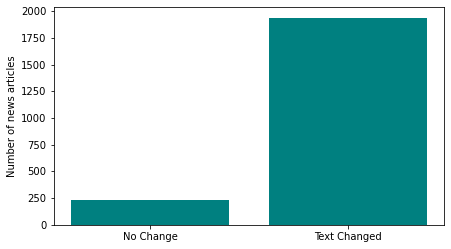

In [23]:
#Figure to visualize the number of articles that had ASCII Characters removed 
fig = plt.figure(figsize = (7, 4))
 
# creating the bar plot
plt.bar(df_temp['indicator'], df_temp[0], color ='teal',
        width = 0.8)
 
plt.xlabel("")
plt.ylabel("Number of news articles")
#plt.title("Figure 2 : News Articles after ASCII characters were removed")
plt.show()

EDA & Pre-Processing 4 - Removing the letter editor rows from the dataframe  - this was found by running sample function multiple times through the course of the project.


In [24]:
#list that contains the partial string 
discard = ["A letter from the Editor Dear subscriber"]

#removing from dataframe
df = df[~df.text_clean.str.contains('|'.join(discard))]

df.shape
#Around 8 rows have been removed

(2162, 9)

In [25]:
#Only getting the required column 
df_tf = df[['text_clean']]
#Chaning it to list
dta = df_tf.values.tolist()
#Convert all text to lowercase
dta2 = [str (item) for item in dta]

EDA & Pre-Processing 5 - Lemmatization and Stop Word Removal

In [26]:
#Creating lemmatization object
lemmmatizer=WordNetLemmatizer()


#Removing English stopwords
stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(["migrant", "migrants", "migration", "state", "worker", "workers", "said", "say", "mr", "u", "also", "labourer", "labourers"])

lemmatizer = WordNetLemmatizer()



In [27]:
len(dta2)

2162

In [28]:
# For Loop that performs lemmatization of article texts
data_without_stopwords = []
for i in range(0, len(dta2)):
    doc = re.sub('[^a-zA-Z]', ' ', dta2[i])
    doc = doc.lower()
    doc = doc.split()
    doc = [lemmatizer.lemmatize(word) for word in doc if not word in set(stopwords)]
    doc = ' '.join(doc)
    data_without_stopwords.append(doc)

In [29]:
#Checking initial text
print(dta2[0])


['Bihar, Punjab and Telangana on Thursday joined three other states in demanding that the Centre run special trains to take migrants stranded in the wake of the lockdown in various parts of the country, saying transporting the workers in buses to their home states was not feasible. Earlier, the chief ministers of Maharashtra, Kerala and Chhattisgarh had demanded that railways should be utilised to ferry the stranded workers to their home states.The demand for special trains gained momentum a day after the Union ministry of home affairs (MHA) allowed inter-state movement by road to facilitate the return of people who are stuck in various cities for the last five months.In a letter to PM Narendra Modi, Punjab chief minister Amarinder Singh cited the MHAs orders and said given the large number of workers stuck due to the lockdown, the use of buses for their transportation would not work. Estimates indicate that nearly one million workers will need transport to go back to their states, he 

In [30]:
#Checking Lemmatized text
print(data_without_stopwords[0])


bihar punjab telangana thursday joined three state demanding centre run special train take stranded wake lockdown various part country saying transporting bus home state feasible earlier chief minister maharashtra kerala chhattisgarh demanded railway utilised ferry stranded home state demand special train gained momentum day union ministry home affair mha allowed inter movement road facilitate return people stuck various city last five month letter pm narendra modi punjab chief minister amarinder singh cited mhas order given large number stuck due lockdown use bus transportation would work estimate indicate nearly one million need transport go back state observed adding feasible option circumstance arrange special train railway may run point point keeping view number person transported given destination bihar deputy cm sushil modi echoed amarinders view number huge many stranded faraway place like chennai bangalore mumbai bus take six seven day go come back practically feasible bring m

In [31]:
#Saving the lemmatized result as a new dataframe
text_clean2 = pd.DataFrame(data_without_stopwords)

In [32]:
#Rename columns
text_clean2 = text_clean2.rename(columns= {0: 'text_clean2'})
#Count of words after lemmatization
text_clean2['text_count2'] = text_clean2['text_clean2'].str.len()

In [33]:
#Check dataframe
text_clean2

text_clean2  text_count2
0     bihar punjab telangana thursday joined three s...         1928
1     couple convinces cop let pas lockdown surat di...          759
2     surat despite repeated attempt srikant yadav t...         1298
3     kolhapur police personnel deployed sangli bord...          995
4     nepali national arrived sasaram patna thursday...         2342
...                                                 ...          ...
2157  met sdrf pm care fund government come detailed...         1553
2158  finding employment come first whether home bac...         2548
2159  slammed chief minister mamata banerjee relucta...         2133
2160  child enrol class ernakulam nearly one third c...         1400
2161  greater surveillance railway station entry res...         1387

[2162 rows x 2 columns]

In [34]:
#Boxplot - to check for outliers - after lemmatization 
fig = px.box(text_clean2, y='text_count2',#title = "Figure 3:Number of Words after lemmatization", 
                  labels = {'text_count2' : 'Number of Words in Article'},
                  color_discrete_sequence = ['teal'], width=450)

fig
#fig.write_image("fig1.png")

In [35]:
text_clean2.describe()

text_count2
count   2162.000000
mean    1332.450971
std      673.368849
min       38.000000
25%      905.000000
50%     1249.000000
75%     1628.000000
max    10321.000000

EDA & Pre-Processing 6 - Visualizing the most frequently occuring words in the lemmatized text column. This is to give an idea for Topic Modelling topics.


In [36]:
#Convert lemmatized text column to list
text_list = list(text_clean2['text_clean2'])
text_list[0]

'bihar punjab telangana thursday joined three state demanding centre run special train take stranded wake lockdown various part country saying transporting bus home state feasible earlier chief minister maharashtra kerala chhattisgarh demanded railway utilised ferry stranded home state demand special train gained momentum day union ministry home affair mha allowed inter movement road facilitate return people stuck various city last five month letter pm narendra modi punjab chief minister amarinder singh cited mhas order given large number stuck due lockdown use bus transportation would work estimate indicate nearly one million need transport go back state observed adding feasible option circumstance arrange special train railway may run point point keeping view number person transported given destination bihar deputy cm sushil modi echoed amarinders view number huge many stranded faraway place like chennai bangalore mumbai bus take six seven day go come back practically feasible bring 

In [37]:
text_list2 = []
#For loop to split the content
for i in range(0, len(text_list)):
    chunks = text_list[i].split(' ')
    text_list2.append(chunks)


In [38]:
#Changing list of lists to one big list
flat_text_list = [item for sublist in text_list2 for item in sublist]


In [39]:
#Removing some punctuations
flat_text_list = [element.replace(' ', '') for element in flat_text_list]
flat_text_list = [element.replace('"', '') for element in flat_text_list]
flat_text_list = [element.replace('[', '') for element in flat_text_list]
flat_text_list = [element.replace(']', '') for element in flat_text_list]
flat_text_list = [element.replace("'", '') for element in flat_text_list]
flat_text_list = [element.replace(",", '') for element in flat_text_list]

#Converting it to dataframe
words = pd.DataFrame(flat_text_list)
words

0
0           bihar
1          punjab
2       telangana
3        thursday
4          joined
...           ...
395898     better
395899    welfare
395900  programme
395901    legally
395902     return

[395903 rows x 1 columns]

In [40]:
#Rename column
words = words.rename(columns= {0: 'word'})
#Grouping by to find count of each word in the dataframe
word_temp = words.groupby('word').size().reset_index()
word_temp = word_temp.rename(columns= {0: 'word_count'})

In [41]:
#Sort by highest to lowest
word_temp = word_temp.sort_values(['word_count'], ascending = False)
word_temp2 = word_temp.head(20)
word_temp2 = word_temp2.sort_values(by=['word_count'])

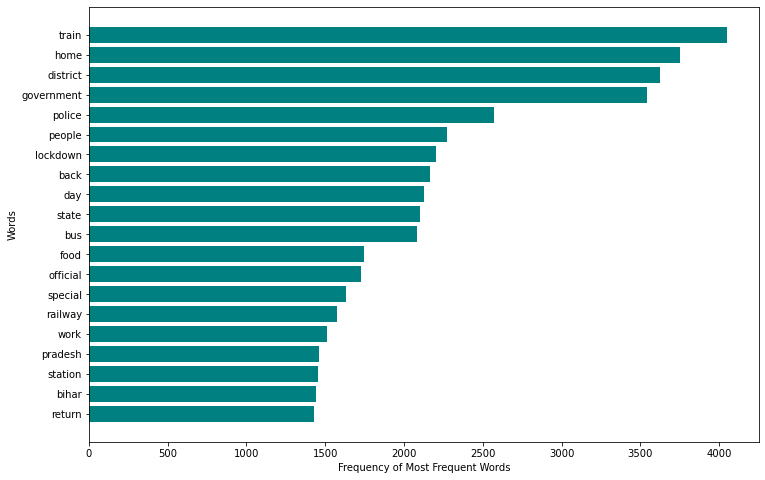

In [42]:
#visualizing the most important words - after doing some punctuation removal
fig = plt.figure(figsize = (12, 8))
 
# creating the bar plot
plt.barh(word_temp2['word'], word_temp2['word_count'], color ='teal', height=0.8)
plt.xlabel("Frequency of Most Frequent Words")
plt.ylabel("Words")
#plt.title("Figure 5 : Most Frequently occuring words")
plt.show()

SENTIMENT ANALYSIS

In [43]:
#Sentiment analysis of text column from text_clean2 (in which stop words are removed and lemmatization performed)
text_clean2

text_clean2  text_count2
0     bihar punjab telangana thursday joined three s...         1928
1     couple convinces cop let pas lockdown surat di...          759
2     surat despite repeated attempt srikant yadav t...         1298
3     kolhapur police personnel deployed sangli bord...          995
4     nepali national arrived sasaram patna thursday...         2342
...                                                 ...          ...
2157  met sdrf pm care fund government come detailed...         1553
2158  finding employment come first whether home bac...         2548
2159  slammed chief minister mamata banerjee relucta...         2133
2160  child enrol class ernakulam nearly one third c...         1400
2161  greater surveillance railway station entry res...         1387

[2162 rows x 2 columns]

In [44]:
text_clean_copy = text_clean2.copy()
text_clean_copy

text_clean2  text_count2
0     bihar punjab telangana thursday joined three s...         1928
1     couple convinces cop let pas lockdown surat di...          759
2     surat despite repeated attempt srikant yadav t...         1298
3     kolhapur police personnel deployed sangli bord...          995
4     nepali national arrived sasaram patna thursday...         2342
...                                                 ...          ...
2157  met sdrf pm care fund government come detailed...         1553
2158  finding employment come first whether home bac...         2548
2159  slammed chief minister mamata banerjee relucta...         2133
2160  child enrol class ernakulam nearly one third c...         1400
2161  greater surveillance railway station entry res...         1387

[2162 rows x 2 columns]

In [45]:
#Initialize sentiment analysis object from VADER
sentiment_obj = SentimentIntensityAnalyzer()

In [46]:
def sentiment_analysis(article):
    """
    ----------------------------------------------------------------------------------------------------------------------------
    This function takes in a string and finds its sentiment score, and returns the sentiment dictionary
    ----------------------------------------------------------------------------------------------------------------------------
    Argument  : article of string type
    ----------------------------------------------------------------------------------------------------------------------------
    Return type : sentiment score of dictionary type
    ----------------------------------------------------------------------------------------------------------------------------
    """
    sentiment_scores = sentiment_obj.polarity_scores(article)
    
    ## return sentiment dict
    return(sentiment_scores)

#Function call
all_dicts = [sentiment_analysis(article) for article in text_clean2.text_clean2]

In [47]:
all_dicts

[{'neg': 0.066, 'neu': 0.785, 'pos': 0.149, 'compound': 0.9747},
 {'neg': 0.034, 'neu': 0.847, 'pos': 0.119, 'compound': 0.7717},
 {'neg': 0.088, 'neu': 0.833, 'pos': 0.079, 'compound': -0.25},
 {'neg': 0.072, 'neu': 0.906, 'pos': 0.021, 'compound': -0.7713},
 {'neg': 0.076, 'neu': 0.827, 'pos': 0.097, 'compound': 0.6675},
 {'neg': 0.0, 'neu': 0.945, 'pos': 0.055, 'compound': 0.3818},
 {'neg': 0.03, 'neu': 0.864, 'pos': 0.106, 'compound': 0.9081},
 {'neg': 0.015, 'neu': 0.865, 'pos': 0.12, 'compound': 0.9451},
 {'neg': 0.0, 'neu': 0.868, 'pos': 0.132, 'compound': 0.9477},
 {'neg': 0.068, 'neu': 0.834, 'pos': 0.098, 'compound': 0.1027},
 {'neg': 0.056, 'neu': 0.846, 'pos': 0.098, 'compound': 0.5267},
 {'neg': 0.023, 'neu': 0.915, 'pos': 0.062, 'compound': 0.5267},
 {'neg': 0.059, 'neu': 0.833, 'pos': 0.108, 'compound': 0.7966},
 {'neg': 0.053, 'neu': 0.803, 'pos': 0.144, 'compound': 0.8316},
 {'neg': 0.034, 'neu': 0.861, 'pos': 0.105, 'compound': 0.9886},
 {'neg': 0.051, 'neu': 0.863, '

In [48]:
#Convert it to a dataframe
all_dicts_df = pd.DataFrame(all_dicts)

## add to main data
text_clean2 = pd.concat([text_clean2.reset_index(), 
                        all_dicts_df.reset_index()], axis = 1)

In [49]:
#Dropping unnecessary columns 
sentiment_df = text_clean2.drop(['index', 'text_count2'], axis=1)

#new[['id', 'contents', 'neg']].sort_values(by = 'neg', 
              #  ascending = False).head(2)

In [50]:
sentiment_df = sentiment_df.rename(columns= {'text_clean2': 'article_text'})
sentiment_df

article_text    neg    neu    pos  \
0     bihar punjab telangana thursday joined three s...  0.066  0.785  0.149   
1     couple convinces cop let pas lockdown surat di...  0.034  0.847  0.119   
2     surat despite repeated attempt srikant yadav t...  0.088  0.833  0.079   
3     kolhapur police personnel deployed sangli bord...  0.072  0.906  0.021   
4     nepali national arrived sasaram patna thursday...  0.076  0.827  0.097   
...                                                 ...    ...    ...    ...   
2157  met sdrf pm care fund government come detailed...  0.090  0.741  0.170   
2158  finding employment come first whether home bac...  0.055  0.799  0.146   
2159  slammed chief minister mamata banerjee relucta...  0.117  0.728  0.155   
2160  child enrol class ernakulam nearly one third c...  0.048  0.817  0.135   
2161  greater surveillance railway station entry res...  0.084  0.749  0.167   

      compound  
0       0.9747  
1       0.7717  
2      -0.2500  
3      -0.7713  
4       0.6675  
...        ...  
2157    0.9517  
2158    0.9852  
2159    0.8356  
2160    0.9022  
2161    0.9001  

[2162 rows x 5 columns]

In [51]:
#Most negative scores 
sentiment_df[['article_text', 'neg']].sort_values(by = 'neg', ascending = False).head(10)

article_text    neg
1999  government term revenge attack family slain li...  0.381
1089  surat video bihar shot death go viral surat vi...  0.379
348   lucknow many lost life covid lockdown virus ro...  0.364
1008  hyderabad partially burnt body year old bihar ...  0.356
1850  accident tool place village mahua near panwari...  0.353
1069  surat bihar allegedly lynched group men pandes...  0.340
1190  surat police registered offence culpable homic...  0.340
1109  surat three day bihar lynched pandesara police...  0.336
2036  tiruppur city police friday arrested three per...  0.329
1783  least others injured incident eight including ...  0.312

In [52]:
#Most positive scores 
sentiment_df[['article_text', 'pos']].sort_values(by = 'pos', ascending = False).head(10)

article_text    pos
310   exclusive interaction etimes actress zareen kh...  0.522
1932  maharashtra minister nationalist congress part...  0.378
620   yesterday morning sonu sood woke two surprise ...  0.363
1590  dont need pity fundamental right need protecte...  0.320
1051  bareilly district administration kheri organis...  0.313
663   happy announce travelled bus day yesterday rea...  0.302
1967  ramzan year remained low key celebration mass ...  0.300
1178  special counter set screening traveller varana...  0.298
704   hyderabad telangana congress launched web port...  0.297
521   prayagraj taking serious note auraiyya road mi...  0.296

In [53]:
#Column added to make plotting easy for later
sentiment_df['article_seq'] = np.arange(len(sentiment_df))+1
sentiment_df

article_text    neg    neu    pos  \
0     bihar punjab telangana thursday joined three s...  0.066  0.785  0.149   
1     couple convinces cop let pas lockdown surat di...  0.034  0.847  0.119   
2     surat despite repeated attempt srikant yadav t...  0.088  0.833  0.079   
3     kolhapur police personnel deployed sangli bord...  0.072  0.906  0.021   
4     nepali national arrived sasaram patna thursday...  0.076  0.827  0.097   
...                                                 ...    ...    ...    ...   
2157  met sdrf pm care fund government come detailed...  0.090  0.741  0.170   
2158  finding employment come first whether home bac...  0.055  0.799  0.146   
2159  slammed chief minister mamata banerjee relucta...  0.117  0.728  0.155   
2160  child enrol class ernakulam nearly one third c...  0.048  0.817  0.135   
2161  greater surveillance railway station entry res...  0.084  0.749  0.167   

      compound  article_seq  
0       0.9747            1  
1       0.7717            2  
2      -0.2500            3  
3      -0.7713            4  
4       0.6675            5  
...        ...          ...  
2157    0.9517         2158  
2158    0.9852         2159  
2159    0.8356         2160  
2160    0.9022         2161  
2161    0.9001         2162  

[2162 rows x 6 columns]

In [54]:
def polarity_score(compound):
    """
    ------------------------------------------------------------------------------------------------------------------------
    This function classifies each article text based on the compound polarity score from VADER
    ------------------------------------------------------------------------------------------------------------------------
    Argument  : compound of float type 
    ----------------------------------------------------------------------------------------------------------------------------
    Return type : string (either positive, negative, neutral)
    """
    
    if(compound > 0.05):
        return "positive"
    elif(compound < -0.05):
        return "negative"
    elif(compound>=(-0.05) and compound<0.05):
        return "neutral"

#Function call using list comprehension
sentiment_df['sentiment_vader'] = [polarity_score(compound) for compound in sentiment_df.compound]

In [55]:
sentiment_df.sample(10)

article_text    neg    neu    pos  \
1032  bengaluru brought food u thats question greets...  0.079  0.817  0.104   
1188  view current labour shortage punjab plan bring...  0.128  0.716  0.156   
938              face shield added protection step home  0.000  1.000  0.000   
1414  seek common policy unified command structure c...  0.047  0.790  0.163   
854   l construction bengaluru income last fortnight...  0.083  0.829  0.088   
1806  secure job contract limited use acquired skill...  0.089  0.729  0.181   
1154  kolkata centre asked bengal engage jobless flo...  0.025  0.893  0.082   
317   varanasi eight new covid positive detected fou...  0.092  0.747  0.161   
991   coronavirus coronavirus coronavirus coronaviru...  0.105  0.737  0.158   
1920  demand end dilution labour law ten central tra...  0.101  0.820  0.080   

      compound  article_seq sentiment_vader  
1032    0.7351         1033        positive  
1188    0.9101         1189        positive  
938     0.0000          939         neutral  
1414    0.9432         1415        positive  
854     0.1280          855        positive  
1806    0.9882         1807        positive  
1154    0.6908         1155        positive  
317     0.9716          318        positive  
991     0.9690          992        positive  
1920    0.1280         1921        positive

In [56]:
sentiment_df.dtypes

article_text        object
neg                float64
neu                float64
pos                float64
compound           float64
article_seq          int32
sentiment_vader     object
dtype: object

In [57]:
#Making sure all sentiments are either positive, negative, neutral
sentiment_df['sentiment_vader'].unique()

array(['positive', 'negative', 'neutral'], dtype=object)

In [58]:
#Finding the counts of each sentiment
sentiment_df_temp1 = sentiment_df.groupby('sentiment_vader').size().reset_index()
sentiment_df_temp1 = sentiment_df_temp1.sort_values(by=['sentiment_vader'], ascending=False)
sentiment_df_temp1 = sentiment_df_temp1.rename(columns= {0: 'sentiment_vader_count'})
sentiment_df_temp1

sentiment_vader  sentiment_vader_count
2        positive                   1413
1         neutral                     31
0        negative                    718

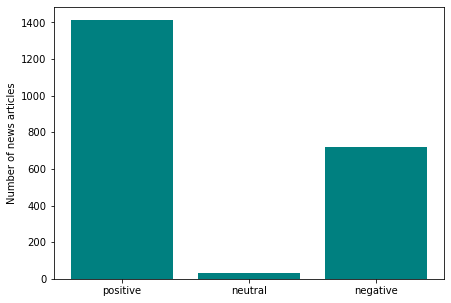

In [59]:
#Plot to find the distribution of sentiment classifications using VADER
fig = plt.figure(figsize = (7, 5))
 
# creating the bar plot
plt.bar(sentiment_df_temp1['sentiment_vader'], sentiment_df_temp1['sentiment_vader_count'], color ='teal')

plt.xlabel("")
plt.ylabel("Number of news articles")
#plt.title("Figure : Distribution of VADER Sentiments in Articles")
plt.show()

In [60]:
#Create a function to get the polarity with TextBlob
def getPolarity(text):
    """
    ----------------------------------------------------------------------------------------------------------------------------
    This function takes in a string and finds its sentiment score, and returns the textblob score
    ----------------------------------------------------------------------------------------------------------------------------
    Argument  : text of string type
    ----------------------------------------------------------------------------------------------------------------------------
    Return type : TextBlob score of float type
    ----------------------------------------------------------------------------------------------------------------------------
    """
    return TextBlob(text).sentiment.polarity

#Function call to find textblob score
sentiment_df['textblob_score'] = [getPolarity(article) for article in text_clean2.text_clean2]

In [61]:
def getAnalysis(score):
    """
    ----------------------------------------------------------------------------------------------------------------------------
    This function takes the TextBlob score and classifies the sentiment accordingly
    ----------------------------------------------------------------------------------------------------------------------------
    Argument  : TextBlob score
    ----------------------------------------------------------------------------------------------------------------------------
    Return type : sentiment classification
    ----------------------------------------------------------------------------------------------------------------------------
    """
    if score < 0:
        return "negative"
    elif score == 0:
        return "neutral"
    else:
        return "positive"

#Function call
sentiment_df['sentiment_textblob'] =  sentiment_df['textblob_score'].apply(getAnalysis)

In [62]:
#An indicator to check if sentiment classification from VADER and TextBlob match
sentiment_df['indicator'] = np.where((sentiment_df['sentiment_vader'] == sentiment_df['sentiment_textblob']), "Same Sentiment", "Sentiments do not Match")

In [63]:
sentiment_df_temp = sentiment_df.groupby('indicator').size().reset_index()
sentiment_df_temp = sentiment_df_temp.rename(columns= {0: 'sentiment_match'})

sentiment_df_temp

indicator  sentiment_match
0           Same Sentiment             1571
1  Sentiments do not Match              591

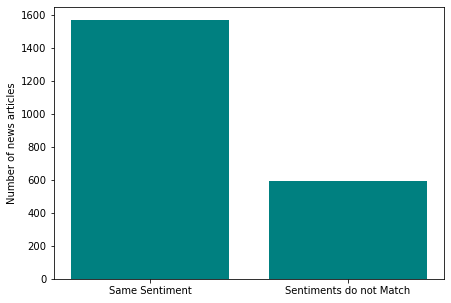

In [64]:
#Plots to check sentiment matching across VADER and TextBlob
fig = plt.figure(figsize = (7, 5))
 
# creating the bar plot
plt.bar(sentiment_df_temp['indicator'], sentiment_df_temp['sentiment_match'], color ='teal')
 
plt.xlabel("")
plt.ylabel("Number of news articles")
#plt.title("Figure : Sentiment Matching across VADER and TextBlob")
plt.show()

Text(0, 0.5, 'Text Blob Polarity Scores')

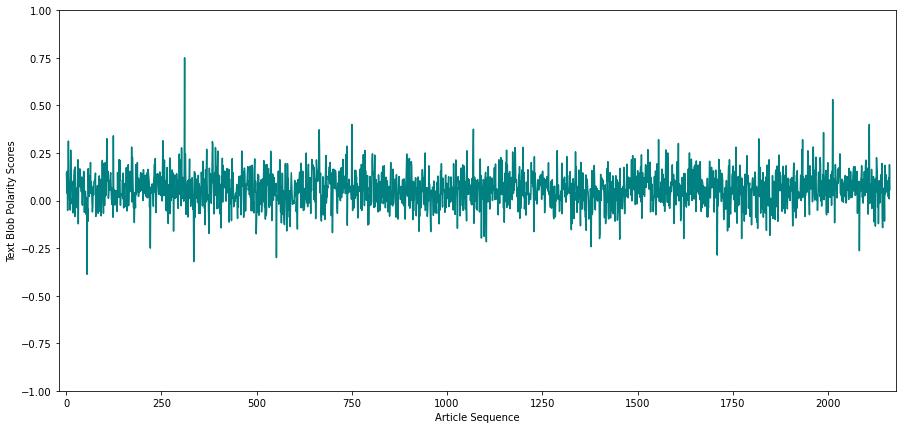

In [65]:
#Graph the polarity probability from TextBlob

plt.figure(figsize=(15, 7))
plt.plot(sentiment_df['article_seq'],  sentiment_df['textblob_score'], color='teal')
#plt.plot(sentiment_df2['article_seq'],  sentiment_df2['pos'], color='indianred', label="positive polarity score")
#plt.plot(sentiment_df2['article_seq'],  sentiment_df2['neu'], color='teal', label="neutral polarity score")
plt.ylim(-1, 1)
plt.xlim(-18.8, 2178)
#plt.title('Figure : Polarity Scores of Articles with Text Blob')
plt.xlabel('Article Sequence')
plt.ylabel('Text Blob Polarity Scores')
#plt.legend(loc='upper right')

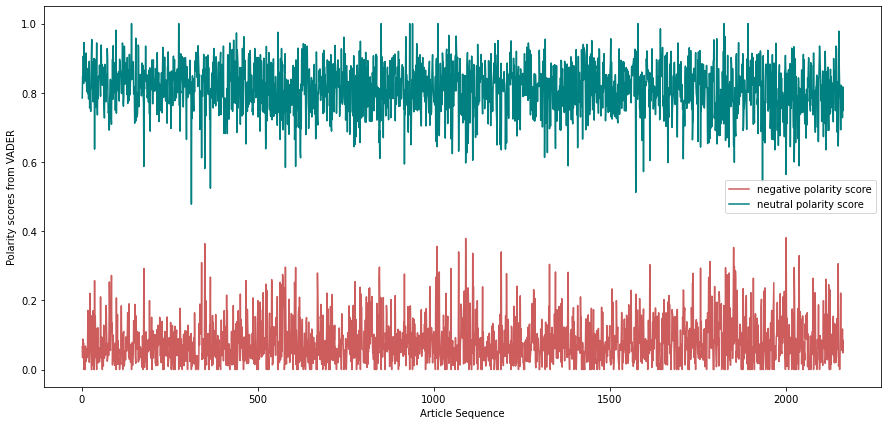

In [66]:
#Graph the VADER polarity probability for neutral and negative

plt.figure(figsize=(15, 7))
plt.plot(sentiment_df['article_seq'],  sentiment_df['neg'], color='indianred', label="negative polarity score")

#plt.plot(sentiment_df2['article_seq'],  sentiment_df2['pos'], color='indianred', label="positive polarity score")
plt.plot(sentiment_df['article_seq'],  sentiment_df['neu'], color='teal', label="neutral polarity score")
plt.ylim(-0.05, 1.05)
plt.title('')
plt.xlabel('Article Sequence')
plt.ylabel('Polarity scores from VADER')
plt.legend(loc='right')


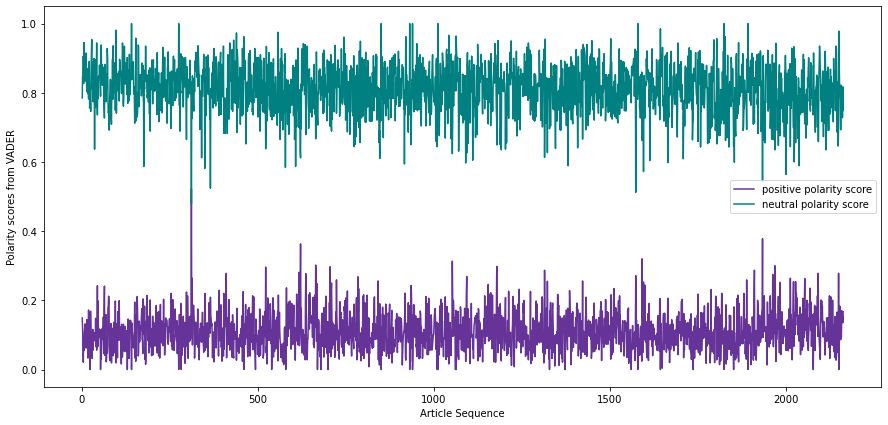

In [67]:
#Graph the polarity probability for neutral and positive

plt.figure(figsize=(15, 7))
#plt.plot(sentiment_df2['article_seq'],  sentiment_df2['neg'], color='rebeccapurple', label="negative polarity score")

plt.plot(sentiment_df['article_seq'],  sentiment_df['pos'], color='rebeccapurple', label="positive polarity score")
plt.plot(sentiment_df['article_seq'],  sentiment_df['neu'], color='teal', label="neutral polarity score")
plt.ylim(-0.05, 1.05)
plt.title('')
plt.xlabel('Article Sequence')
plt.ylabel('Polarity scores from VADER')
plt.legend(loc='right')


In [68]:
#Sentiment Analysis Done

Topic Modelling 

In [69]:
text_tm = text_clean_copy['text_clean2']
text_tm

0       bihar punjab telangana thursday joined three s...
1       couple convinces cop let pas lockdown surat di...
2       surat despite repeated attempt srikant yadav t...
3       kolhapur police personnel deployed sangli bord...
4       nepali national arrived sasaram patna thursday...
                              ...                        
2157    met sdrf pm care fund government come detailed...
2158    finding employment come first whether home bac...
2159    slammed chief minister mamata banerjee relucta...
2160    child enrol class ernakulam nearly one third c...
2161    greater surveillance railway station entry res...
Name: text_clean2, Length: 2162, dtype: object

LDA using tf-idf

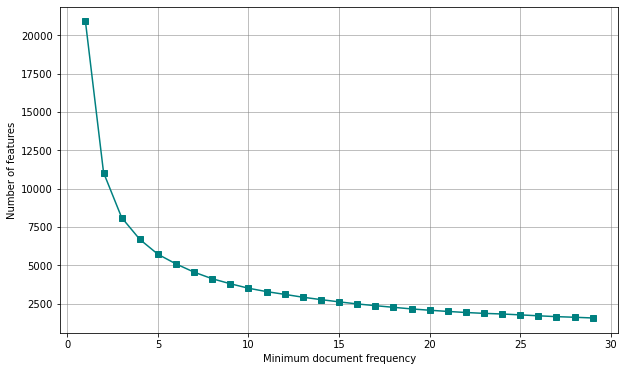

In [70]:
count_list = []
count_features = []

#Loop to find the number of features when minimum document frequency ranges from 1 to 2170
for i in range(1, 30):
    bin_vect = CountVectorizer(stop_words="english",min_df=i, binary=True)
    bin_dtm = bin_vect.fit_transform(text_tm[0:2162])
    term_indices = {index: term for term, index in bin_vect.vocabulary_.items()}
    colterms = [term_indices[i] for i in range(bin_dtm.shape[1])]
    #print(i, "\t", len(colterms), "\n")
    count_list.append(i)
    count_features.append(len(colterms))

#Plotting the result
plt.figure(figsize=(10,6))
plt.plot(count_list, count_features, marker = 's', color='teal')
plt.xlabel('Minimum document frequency')
plt.ylabel('Number of features')
#plt.title('Number of features for each document frequency')
plt.grid(color='grey', linewidth=0.5)
plt.show()

In [71]:
tfidf_vect = TfidfVectorizer(min_df=5, stop_words='english')
tfidf = tfidf_vect.fit_transform(text_tm)
tfidf.shape

(2162, 5719)

In [72]:
LDA = LatentDirichletAllocation(n_components=5,random_state=5000, learning_method='batch')

In [73]:
# document-topic matrix (probabilities)
theta = LDA.fit_transform(tfidf)
theta.shape

(2162, 5)

In [74]:
# topic-word matrix
beta = LDA.components_
beta.shape

(5, 5719)

In [75]:
beta

array([[ 0.21611104,  0.20002741,  0.21923348, ...,  0.97711766,
         0.20099996,  0.201802  ],
       [ 3.8987678 ,  0.89833959,  2.5204086 , ...,  1.30794373,
         1.59307284, 12.5393264 ],
       [ 0.20006261,  0.20006706,  0.20007358, ...,  0.20007887,
         0.200066  ,  0.20006437],
       [ 0.20006309,  0.20006757,  0.20007415, ...,  0.20007948,
         0.2000665 ,  0.20005198],
       [ 0.20009699,  0.20006378,  0.20007001, ...,  0.20007554,
         0.20062347,  0.20054009]])

In [76]:
# topic-word matrix (probabilities)
beta_prob = LDA.components_ / LDA.components_.sum(axis=1)[:, np.newaxis]
beta_prob

array([[8.01782695e-05, 7.42111625e-05, 8.13367104e-05, ...,
        3.62515505e-04, 7.45719819e-05, 7.48695423e-05],
       [2.23298497e-04, 5.14516097e-05, 1.44354186e-04, ...,
        7.49113271e-05, 9.12418457e-05, 7.18178892e-04],
       [1.73648180e-04, 1.73652039e-04, 1.73657700e-04, ...,
        1.73662290e-04, 1.73651119e-04, 1.73649706e-04],
       [1.74746423e-04, 1.74750338e-04, 1.74756078e-04, ...,
        1.74760734e-04, 1.74749403e-04, 1.74736717e-04],
       [1.66709245e-04, 1.66681573e-04, 1.66686761e-04, ...,
        1.66691367e-04, 1.67147877e-04, 1.67078408e-04]])

In [77]:
# review top words
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message, '\n')
    print()

In [78]:
features = tfidf_vect.get_feature_names_out()
print_top_words(model=LDA, feature_names = features, n_top_words = 50)

Topic #0: court government bench scheme congress employment minister justice crore lakh party gandhi industry job skill chief union centre rural labour card india provide crisis petition country mgnrega leader supreme hearing economy poor policy adityanath lockdown sector economic state issue advocate bjp work development modi hc yogi cm skilled president package 

Topic #1: train district police home bus government people railway state special day official station food lockdown bihar pradesh return quarantine case work village stranded covid centre number family passenger city place administration sent delhi shelter native lakh shramik travel left help border group uttar officer kumar odisha maharashtra minister positive health 

Topic #2: swain amroli bhanjanagar satyawan amounting homicide culpable nhrc brahmbhatt smimer rb weaving padmanabh thrashed thrashing anjani killing truth widow murder dismissed complainant liberty surprising sujit santosh postmortem mentally elder challenge

LDA using Gensim

In [79]:
## tokenize text
tokenized_text = [wordpunct_tokenize(article)
                  for article in text_clean_copy.text_clean2]
tokenized_text

[['bihar',
  'punjab',
  'telangana',
  'thursday',
  'joined',
  'three',
  'state',
  'demanding',
  'centre',
  'run',
  'special',
  'train',
  'take',
  'stranded',
  'wake',
  'lockdown',
  'various',
  'part',
  'country',
  'saying',
  'transporting',
  'bus',
  'home',
  'state',
  'feasible',
  'earlier',
  'chief',
  'minister',
  'maharashtra',
  'kerala',
  'chhattisgarh',
  'demanded',
  'railway',
  'utilised',
  'ferry',
  'stranded',
  'home',
  'state',
  'demand',
  'special',
  'train',
  'gained',
  'momentum',
  'day',
  'union',
  'ministry',
  'home',
  'affair',
  'mha',
  'allowed',
  'inter',
  'movement',
  'road',
  'facilitate',
  'return',
  'people',
  'stuck',
  'various',
  'city',
  'last',
  'five',
  'month',
  'letter',
  'pm',
  'narendra',
  'modi',
  'punjab',
  'chief',
  'minister',
  'amarinder',
  'singh',
  'cited',
  'mhas',
  'order',
  'given',
  'large',
  'number',
  'stuck',
  'due',
  'lockdown',
  'use',
  'bus',
  'transportation',

In [80]:
text_proc_dict = corpora.Dictionary(tokenized_text)

### filter dictionary
text_proc_dict.filter_extremes(no_above = 0.70)

### create corpus from dictionary
corpus_fromdict_proc = [text_proc_dict.doc2bow(one_text) 
                   for one_text in tokenized_text]

In [81]:
print(text_proc_dict)

Dictionary<5905 unique tokens: ['across', 'adding', 'affair', 'allow', 'allowed']...>


In [82]:
n_topics = 5
ldamod_proc = gensim.models.ldamodel.LdaModel(corpus_fromdict_proc, 
                                         num_topics = n_topics, id2word=text_proc_dict, passes=20, alpha = 'auto',
                                        per_word_topics = True, random_state = 5000)

In [83]:
### print topics and words
topics = ldamod_proc.print_topics(num_words = 10)
for topic in topics:
    print(topic)

(0, '0.039*"train" + 0.017*"special" + 0.014*"railway" + 0.013*"home" + 0.013*"bus" + 0.010*"government" + 0.010*"state" + 0.009*"shramik" + 0.009*"official" + 0.009*"station"')
(1, '0.013*"home" + 0.013*"police" + 0.010*"back" + 0.008*"lockdown" + 0.008*"district" + 0.008*"food" + 0.008*"work" + 0.007*"day" + 0.007*"bus" + 0.006*"village"')
(2, '0.021*"court" + 0.015*"government" + 0.008*"bench" + 0.007*"state" + 0.007*"home" + 0.006*"train" + 0.006*"lockdown" + 0.006*"high" + 0.006*"centre" + 0.005*"would"')
(3, '0.022*"district" + 0.014*"case" + 0.013*"quarantine" + 0.012*"covid" + 0.011*"government" + 0.011*"centre" + 0.009*"official" + 0.008*"people" + 0.007*"health" + 0.006*"day"')
(4, '0.011*"government" + 0.011*"work" + 0.008*"minister" + 0.008*"lockdown" + 0.007*"year" + 0.007*"lakh" + 0.006*"village" + 0.006*"job" + 0.006*"district" + 0.005*"scheme"')


In [84]:
pyLDAvis.enable_notebook()
lda_display_proc = gensimvis.prepare(ldamod_proc, corpus_fromdict_proc, text_proc_dict)
pyLDAvis.display(lda_display_proc)
